In [1]:
import pandas as pd
import numpy as np

### 1. Data Understanding

In [49]:
import os
import re

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

#### 1.1. Data Cleansing

In [46]:
!head -1 rna002_RTRS_2017_11_29.csv

DATE,TIME,UNIQUE_STORY_INDEX,EVENT_TYPE,PNAC,STORY_DATE_TIME,TAKE_DATE_TIME,HEADLINE_ALERT_TEXT,ACCUMULATED_STORY_TEXT,TAKE_TEXT,PRODUCTS,TOPICS,RELATED_RICS,NAMED_ITEMS,HEADLINE_SUBTYPE,STORY_TYPE,TABULAR_FLAG,ATTRIBUTION,LANGUAGE


###### Note

- Data in CSV format with comma separator & include HEADER
- This can be load by spark sql (for production) and pandas (for experiement)

In [45]:
!head -40 rna002_RTRS_2017_11_29.csv | tail -23

2013-06-01,00:00:51.439,"20130601000050nL2N0EC22A","STORY_TAKE_OVERWRITE","nL2N0EC22A","2013-06-01 00:00:50","","ONU pede à Grã-Bretanha que investigue torturas no Iraque e Afeganistão","","    GENEBRA, 31 Mai (Reuters) - O Comitê Contra a Tortura da ONU 
pediu nesta sexta-feira à Grã-Bretanha que amplie e acelere suas 
investigações sobre supostos abusos cometidos por soldados 
britânicos contra detentos no Iraque e no Afeganistão e que puna 
os responsáveis. 
    ""O Comitê Contra a Tortura está profundamente preocupado com 
o crescente número de acusações sérias de torturas e maus 
tratos, inclusive por cumplicidade, como resultado das 
intervenções militares estatais no Iraque e Afeganistão"", disse 
o órgão da ONU. 
    Seus dez especialistas independentes apresentaram suas 
conclusões após examinarem a atuação da Grã-Bretanha no 
cumprimento das leis internacionais que proíbem a tortura. 
    Muitos iraquianos dizem ter sido torturados por soldados da 
ocupação britânica entre 20

###### Note

- Data contain multiple lines in one column
- Contain multiple double quote "" which not the escape character

###### Asumption

 - not escapse double quote "" is meaningless which will not break the text content structure => can be remove
 - After remove meaningless double quote & standadize the text column which only be wraped inside a proper double quote {open} and {close}, for example: "ABCDD    \n \n ADBC"
 - Finally, just need to handle multiLine column

###### Data Flow to clean data

 1. Simple Spark job to standadize the text column => store the data to immidiate File
 2. Handle multiple line file

In [73]:
def delete_hdfs_file(sc, path):
    if sc is None:
        print('Spark Context is None')
        return
    
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
 
    fs = FileSystem.get(URI(path), sc._jsc.hadoopConfiguration())
    if fs.exists(Path(path)):
        return fs.delete(Path(path))

 <b>#1. Filter job</b>

In [185]:
conf = SparkConf()\
    .setAppName("Cleaning Job")\
    .setMaster("local[*]")
sc = SparkContext(conf=conf)

In [186]:
raw = sc.textFile('rna002_RTRS_2017_11_29.csv')

In [187]:
raw.count()

169592

In [188]:
raw.take(1)

[u'DATE,TIME,UNIQUE_STORY_INDEX,EVENT_TYPE,PNAC,STORY_DATE_TIME,TAKE_DATE_TIME,HEADLINE_ALERT_TEXT,ACCUMULATED_STORY_TEXT,TAKE_TEXT,PRODUCTS,TOPICS,RELATED_RICS,NAMED_ITEMS,HEADLINE_SUBTYPE,STORY_TYPE,TABULAR_FLAG,ATTRIBUTION,LANGUAGE']

In [189]:
clean = raw.filter(lambda x: len(x)>0)\
    .map(lambda x: re.sub(pattern=r'""', string=x, repl=''))\
    .map(lambda x: re.sub(pattern=r'^",', string=x, repl='@@@",'))

In [190]:
output_path = 'clean_rna002_RTRS_2017_11_29.csv'
delete_hdfs_file(sc, output_path)
clean.coalesce(1).saveAsTextFile(output_path)

In [191]:
sc.stop()

<b>#2. Load data job</b>

In [192]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SimpleApp").getOrCreate()

In [193]:
raw = spark.read\
    .option("multiLine", "true")\
    .option("header", "true")\
    .option("inferSchema","true")\
    .option("multiLine","true")\
    .option("quoteMode","ALL")\
    .option("mode","PERMISSIVE")\
    .option("ignoreLeadingWhiteSpace","true")\
    .option("ignoreTrailingWhiteSpace","true")\
    .option("parserLib","UNIVOCITY")\
    .option("escape",'\n')\
    .option("wholeFile","True")\
    .csv('clean_rna002_RTRS_2017_11_29.csv')

In [184]:
spark.stop()

In [194]:
raw.count()

8131

In [195]:
raw.printSchema()

root
 |-- DATE: timestamp (nullable = true)
 |-- TIME: string (nullable = true)
 |-- UNIQUE_STORY_INDEX: string (nullable = true)
 |-- EVENT_TYPE: string (nullable = true)
 |-- PNAC: string (nullable = true)
 |-- STORY_DATE_TIME: timestamp (nullable = true)
 |-- TAKE_DATE_TIME: timestamp (nullable = true)
 |-- HEADLINE_ALERT_TEXT: string (nullable = true)
 |-- ACCUMULATED_STORY_TEXT: string (nullable = true)
 |-- TAKE_TEXT: string (nullable = true)
 |-- PRODUCTS: string (nullable = true)
 |-- TOPICS: string (nullable = true)
 |-- RELATED_RICS: string (nullable = true)
 |-- NAMED_ITEMS: string (nullable = true)
 |-- HEADLINE_SUBTYPE: integer (nullable = true)
 |-- STORY_TYPE: string (nullable = true)
 |-- TABULAR_FLAG: boolean (nullable = true)
 |-- ATTRIBUTION: string (nullable = true)
 |-- LANGUAGE: string (nullable = true)



- Convert to Pandas DataFrame for Data Analysis

In [372]:
df = raw.toPandas()

#### 1.2. Data Analysis

In [373]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

- Check data variables

In [374]:
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8131 entries, 0 to 8130
Data columns (total 19 columns):
DATE                      8131 non-null datetime64[ns]
TIME                      8131 non-null object
UNIQUE_STORY_INDEX        8131 non-null object
EVENT_TYPE                8131 non-null object
PNAC                      8131 non-null object
STORY_DATE_TIME           8131 non-null datetime64[ns]
TAKE_DATE_TIME            4551 non-null datetime64[ns]
HEADLINE_ALERT_TEXT       7176 non-null object
ACCUMULATED_STORY_TEXT    376 non-null object
TAKE_TEXT                 3579 non-null object
PRODUCTS                  7181 non-null object
TOPICS                    7181 non-null object
RELATED_RICS              1504 non-null object
NAMED_ITEMS               1441 non-null object
HEADLINE_SUBTYPE          3238 non-null float64
STORY_TYPE                7181 non-null object
TABULAR_FLAG              7181 non-null object
ATTRIBUTION               7181 non-null object
LANGUAGE               

###### Conclusion
- We are easy to see that there are three columns: HEADLINE_ALERT_TEXT, ACCUMULATED_STORY_TEXT, TAKE_TEXT which are contain text content
- ACCUMULATED_STORY_TEXT: has very bad quality (just only 376 out of 8181 are non-empty) -> will not consider this colum
- HEADLINE_ALERT_TEXT: seems to be title of article
- TAKE_TEXT: looks like the content body of article
- <b>Will use both of these two columns to extract the trending words</b>

In [375]:
df.ATTRIBUTION.value_counts(dropna=False)

RTRS    7181
NaN      950
Name: ATTRIBUTION, dtype: int64

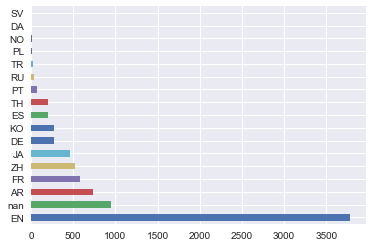

In [376]:
df.LANGUAGE.value_counts(dropna=False).plot(kind = 'barh')

In [377]:
df.PRODUCTS.value_counts().head()

TEST             686
ARNS             581
FA FB SWF DNP    346
KRN DNP          211
S                208
Name: PRODUCTS, dtype: int64

 ###### Asumption
 - English language is the most popular language here
 - It will make sense to just look into only English text here in order to extract the trending keywords (and skip for the other languages)
 - Also filter out 'TEST' products

In [221]:
df_en = df[(df.LANGUAGE=='EN')&(df.PRODUCTS!='TEST')]
print(df_en.shape)

(3100, 19)


In [222]:
print("Empty percentage:")
df_en.isnull().sum() * 100.0/len(df_en)

Empty percentage:


DATE                       0.000000
TIME                       0.000000
UNIQUE_STORY_INDEX         0.000000
EVENT_TYPE                 0.000000
PNAC                       0.000000
STORY_DATE_TIME            0.000000
TAKE_DATE_TIME            48.290323
HEADLINE_ALERT_TEXT        0.193548
ACCUMULATED_STORY_TEXT    96.548387
TAKE_TEXT                 51.709677
PRODUCTS                   0.000000
TOPICS                     0.000000
RELATED_RICS              71.677419
NAMED_ITEMS               76.548387
HEADLINE_SUBTYPE          54.387097
STORY_TYPE                 0.000000
TABULAR_FLAG               0.000000
ATTRIBUTION                0.000000
LANGUAGE                   0.000000
dtype: float64

In [223]:
df_en[['DATE', 'TIME', 'HEADLINE_ALERT_TEXT', 'TAKE_TEXT']].sample(10)

,DATE,TIME,HEADLINE_ALERT_TEXT,TAKE_TEXT
6019,2013-06-03,01:00:15.218,BOJ: c/a balance & market operations (5/31) -...,None
5452,2013-06-02,23:33:29.521,"SERVICE ALERT - RDF+ Svc- Hazelwood PoP, USA -...",None
4788,2013-06-02,21:05:03.468,Angelina Jolie makes first public appearance a...,None
7157,2013-06-03,03:07:57.661,*TOP NEWS* Energy,None
2490,2013-06-01,22:24:56.690,UPDATE 1-Golf-Kuchar moves two ahead at windy ...,* Kuchar takes control with a 70 in gustin...
485,2013-06-01,05:00:21.559,CORRECTED-BRIEF-Mitsubishi to buy Los Grobo Ce...,None
4495,2013-06-02,18:55:28.021,Three storm chasers among 10 killed by Oklahom...,By Daniel Trotta and Jonathan Allen \n ...
8075,2013-06-03,04:56:54.921,*TOP NEWS* Asian Companies,"For expanded, multimedia Reuters Top News visi..."
425,2013-06-01,04:03:05.618,TABLE-Details of Indian govt borrowings in 201...,Jun 1 (Reuters) - The Indian government plans ...
3667,2013-06-02,12:37:07.250,S.Africa investigates Libyan claims on stashed...,"JOHANNESBURG, June 2 (Reuters) - South Afr..."


In [317]:
from pyspark.sql.types import ArrayType, DoubleType, StringType

In [256]:
raw.registerTempTable('temp')

In [332]:
sql='''
    select *, 
        (CASE
            WHEN LANGUAGE<>'EN' THEN ''
            WHEN PRODUCTS=='TEST' THEN ''
            WHEN TAKE_TEXT IS NULL THEN HEADLINE_ALERT_TEXT
            ELSE TAKE_TEXT
        END) as TEXT_CONTENT
    from temp
'''

In [337]:
# process text
def pre_process(text):
    # lowercase
    if text is None:
        return ''
    text=text.lower()
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text.strip()

In [338]:
pre_process_udf = f.udf(pre_process, StringType())

In [341]:
text_df = spark.sql(sqlQuery=sql)\
    .select('DATE', 'TIME', 'LANGUAGE', 'PRODUCTS', pre_process_udf('TEXT_CONTENT').alias('TEXT_CONTENT'))

In [342]:
text_df.show()

+-------------------+------------+--------+--------------------+--------------------+
|               DATE|        TIME|LANGUAGE|            PRODUCTS|        TEXT_CONTENT|
+-------------------+------------+--------+--------------------+--------------------+
|2013-06-01 00:00:00|00:00:00.704|      EN|             E U CAN|mercator minerals...|
|2013-06-01 00:00:00|00:00:00.885|      EN|M D T E C MTL GRO...|s korea says may ...|
|2013-06-01 00:00:00|00:00:01.052|    null|                null|                    |
|2013-06-01 00:00:00|00:00:01.052|      EN|                TEST|                    |
|2013-06-01 00:00:00|00:00:01.055|      EN|                TEST|                    |
|2013-06-01 00:00:00|00:00:01.112|      EN|             E U CAN|mercator minerals...|
|2013-06-01 00:00:00|00:00:01.201|      EN|M D T E C MTL GRO...|s korea says may ...|
|2013-06-01 00:00:00|00:00:01.221|      EN|                TEST|                    |
|2013-06-01 00:00:00|00:00:01.221|      EN|           

### 2. Using simple NLP technique to extract keywords

In [344]:
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer

from pyspark.ml.feature import HashingTF, IDF, Tokenizer

tokenizer = Tokenizer(inputCol="TEXT_CONTENT", outputCol="raw")
remover = StopWordsRemover(inputCol="raw", outputCol="words")
# hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
# idf = IDF(inputCol="rawFeatures", outputCol="features")

cv = CountVectorizer(inputCol="words", outputCol="features")

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, cv])
model = pipeline.fit(text_df)

results = model.transform(text_df)

In [346]:
results.printSchema()

root
 |-- DATE: timestamp (nullable = true)
 |-- TIME: string (nullable = true)
 |-- LANGUAGE: string (nullable = true)
 |-- PRODUCTS: string (nullable = true)
 |-- TEXT_CONTENT: string (nullable = true)
 |-- raw: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)



In [347]:
def extract_values_from_vector(vector):
    return vector.values.tolist()

extract_values_from_vector_udf = f.udf(extract_values_from_vector, ArrayType(DoubleType()))

# And use that UDF to get your values
word_count = results.select('DATE', 'TIME', 'LANGUAGE', extract_values_from_vector_udf('features').alias('count'), 'words')

In [348]:
word_count.show()

+-------------------+------------+--------+--------------------+--------------------+
|               DATE|        TIME|LANGUAGE|               count|               words|
+-------------------+------------+--------+--------------------+--------------------+
|2013-06-01 00:00:00|00:00:00.704|      EN|[1.0, 1.0, 1.0, 1...|[mercator, minera...|
|2013-06-01 00:00:00|00:00:00.885|      EN|[1.0, 1.0, 1.0, 1...|[korea, says, may...|
|2013-06-01 00:00:00|00:00:01.052|    null|               [1.0]|                  []|
|2013-06-01 00:00:00|00:00:01.052|      EN|               [1.0]|                  []|
|2013-06-01 00:00:00|00:00:01.055|      EN|               [1.0]|                  []|
|2013-06-01 00:00:00|00:00:01.112|      EN|[1.0, 1.0, 1.0, 1...|[mercator, minera...|
|2013-06-01 00:00:00|00:00:01.201|      EN|[1.0, 1.0, 2.0, 1...|[korea, says, may...|
|2013-06-01 00:00:00|00:00:01.221|      EN|               [1.0]|                  []|
|2013-06-01 00:00:00|00:00:01.221|      EN|           

- Now we can zip two columns (count and words) and sort by count to have better look about word distribution

In [349]:
import operator

In [356]:
import operator
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(x.items(), key=operator.itemgetter(1))

In [359]:
sorted_x[:2]

[(0, 0), (2, 1)]

In [380]:
import json

In [429]:
def extract_top(count, words, topk=5):
    sorted_x = sorted(zip(words, count), key=operator.itemgetter(1), reverse=True)
    if topk > 0:
        return json.dumps(dict(sorted_x[:topk]))
    else:
        return json.dumps(dict(sorted_x))

In [382]:
extract_top_udf = f.udf(extract_top, StringType())

In [383]:
word_count.select(extract_top_udf('count', 'words')).take(20)

[Row(extract_top(count, words)=u'{"announces": 1.0, "senior": 1.0, "management": 1.0, "minerals": 1.0, "mercator": 1.0}'),
 Row(extract_top(count, words)=u'{"may": 1.0, "korea": 1.0, "says": 1.0, "provisional": 2.0, "trade": 1.0}'),
 Row(extract_top(count, words)=u'{"": 1.0}'),
 Row(extract_top(count, words)=u'{"": 1.0}'),
 Row(extract_top(count, words)=u'{"": 1.0}'),
 Row(extract_top(count, words)=u'{"announces": 1.0, "senior": 1.0, "management": 1.0, "minerals": 1.0, "mercator": 1.0}'),
 Row(extract_top(count, words)=u'{"may": 2.0, "exports": 1.0, "korea": 1.0, "says": 1.0, "pct": 1.0}'),
 Row(extract_top(count, words)=u'{"": 1.0}'),
 Row(extract_top(count, words)=u'{"": 1.0}'),
 Row(extract_top(count, words)=u'{"": 1.0}'),
 Row(extract_top(count, words)=u'{"": 1.0}'),
 Row(extract_top(count, words)=u'{"may": 2.0, "imports": 1.0, "korea": 1.0, "says": 1.0, "pct": 1.0}'),
 Row(extract_top(count, words)=u'{"may": 1.0, "exports": 1.0, "korea": 1.0, "avg": 1.0, "day": 2.0}'),
 Row(extrac

#### Conclusion:

- So here, we can easy to see the frequent word from time to time. However we might need to see the word frequency by time window, for example by hour, day, week ...
- We will need to take advantage of DATE, TIME data. 
- One drawback by using SPARK here is: SPARK is not really convenient to deal with timeseries data and espcially to aggregate data by timewindow. So that we will use Pandas to go a little deep dive (This will only usefor experiment & not production)

##### Convert Spark Dataframe to Pandas

In [431]:
word_count_pd = word_count.select('DATE', 'TIME', extract_top_udf('count', 'words', f.lit(-1)).alias('trending')).toPandas()

In [432]:
word_count_pd.head()

,DATE,TIME,trending
0,2013-06-01,00:00:00.704,"{""announces"": 1.0, ""senior"": 1.0, ""management""..."
1,2013-06-01,00:00:00.885,"{""korea"": 1.0, ""says"": 1.0, ""may"": 1.0, ""revis..."
2,2013-06-01,00:00:01.052,{}
3,2013-06-01,00:00:01.052,{}
4,2013-06-01,00:00:01.055,{}


In [433]:
word_count_pd.dtypes

DATE        datetime64[ns]
TIME                object
trending            object
dtype: object

In [440]:
word_count_pd['DATE_TIME'] = word_count_pd.DATE.dt.strftime('%Y-%m-%d') + ' ' + word_count_pd.TIME
word_count_pd['DATE_TIME'] = pd.to_datetime(word_count_pd['DATE_TIME'])
word_count_pd = word_count_pd.set_index('DATE_TIME')

In [441]:
def calc_freq(x, topK=10):
    super_dict = {}
    dicts = x.map(lambda y: json.loads(y)).values
    for d in dicts:
        for k, v in d.iteritems():  # d.items() in Python 3+
            if k:
                super_dict.setdefault(k, []).append(v)
                
    for k, v in super_dict.iteritems():
        super_dict[k] = sum(v)
        
    sorted_x = sorted(super_dict.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sorted_x[:topK]

In [447]:
word_count_pd.resample('4h').agg({'trending': calc_freq})

,trending
DATE_TIME,
2013-06-01 00:00:00,"[(expanded, 364.0), (reuters, 229.0), (june, 1..."
2013-06-01 04:00:00,"[(reuters, 105.0), (money, 72.0), (north, 63.0..."
2013-06-01 08:00:00,"[(expanded, 270.0), (reuters, 170.0), (june, 1..."
2013-06-01 12:00:00,"[(expanded, 270.0), (june, 199.0), (reuters, 1..."
2013-06-01 16:00:00,"[(expanded, 180.0), (reuters, 123.0), (june, 1..."
2013-06-01 20:00:00,"[(expanded, 360.0), (june, 192.0), (reuters, 1..."
2013-06-02 00:00:00,"[(expanded, 135.0), (june, 50.0), (reuters, 41..."
2013-06-02 04:00:00,"[(expanded, 134.0), (reuters, 54.0), (june, 36..."
2013-06-02 08:00:00,"[(expanded, 271.0), (reuters, 186.0), (june, 1..."


In [449]:
word_count_pd.resample('8h').agg({'trending': calc_freq})

,trending
DATE_TIME,
2013-06-01 00:00:00,"[(expanded, 409.0), (reuters, 334.0), (june, 1..."
2013-06-01 08:00:00,"[(expanded, 540.0), (reuters, 315.0), (june, 3..."
2013-06-01 16:00:00,"[(expanded, 540.0), (june, 314.0), (reuters, 2..."
2013-06-02 00:00:00,"[(expanded, 269.0), (reuters, 95.0), (june, 86..."
2013-06-02 08:00:00,"[(expanded, 630.0), (reuters, 339.0), (june, 2..."
2013-06-02 16:00:00,"[(expanded, 880.0), (june, 352.0), (reuters, 3..."
2013-06-03 00:00:00,"[(expanded, 4021.0), (reuters, 910.0), (june, ..."


In [450]:
word_count_pd.resample('1d').agg({'trending': calc_freq})

,trending
DATE_TIME,
2013-06-01,"[(expanded, 1489.0), (reuters, 879.0), (june, ..."
2013-06-02,"[(expanded, 1779.0), (reuters, 774.0), (june, ..."
2013-06-03,"[(expanded, 4021.0), (reuters, 910.0), (june, ..."


### Conclusion

- We can predict that the text content is talking bout <b>reuters</b> <b>expanded</b> in <b>june</b> ...
- Actually, this is not just basic NLP technique, we can even build something more advanced like LDA - Topic Model or Word2Vector - Sentiment Analysis ...